In [2]:


# Define constants
IMG_HEIGHT = 224
IMG_WIDTH = 224
MAX_FRAMES = 20
NUM_CLASSES = 2  # shop_lifters vs non_shop_lifters
import os
import cv2
import numpy as np
import pandas as pd

# Load and prepare train data
dataset_path = os.listdir(r"C:\Users\DAR-MG\Documents\internship_cellula\video task\Shop DataSet")
Videok = []
for item in dataset_path:
    classes = os.listdir(r"C:\Users\DAR-MG\Documents\internship_cellula\video task\Shop DataSet" + '/' + item)
    for room in classes:
        Videok.append((item, r"C:\Users\DAR-MG\Documents\internship_cellula\video task\Shop DataSet" + '/' + item + '/' + room))

train_df = pd.DataFrame(data=Videok, columns=['tag', 'video_name'])

# Load and prepare test data
dataset_test_path = os.listdir(r"C:\Users\DAR-MG\Documents\internship_cellula\video task\test")
data_set = []
for item in dataset_test_path:
    all_rooms = os.listdir(r"C:\Users\DAR-MG\Documents\internship_cellula\video task\test" + '/' + item)
    for room in all_rooms:
        data_set.append((item, r"C:\Users\DAR-MG\Documents\internship_cellula\video task\test" + '/' + item + '/' + room))

test_df = pd.DataFrame(data=data_set, columns=['tag', 'video_name'])

# Save to CSV
train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index=False)


In [4]:

# Label encoding
labels = train_df['tag'].values
label_map = {'non shop lifters': 0, 'shop lifters': 1}  # Updated to match folder names with spaces
train_labels = np.array([label_map[label] for label in labels])
test_labels = np.array([label_map[label] for label in test_df['tag'].values])

# Function to load and preprocess video frames
def load_video(path, max_frames=MAX_FRAMES, resize=(IMG_WIDTH, IMG_HEIGHT)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, resize)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) / 255.0  # Normalize to [0,1]
            frames.append(frame)
            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    # Pad or truncate frames to MAX_FRAMES
    while len(frames) < MAX_FRAMES:
        frames.append(np.zeros((IMG_HEIGHT, IMG_WIDTH, 3)))
    return np.array(frames)[:MAX_FRAMES]

# Prepare video data
def prepare_video_data(df, root_dir):
    num_samples = len(df)
    video_data = np.zeros((num_samples, MAX_FRAMES, IMG_HEIGHT, IMG_WIDTH, 3))
    for idx, row in df.iterrows():
        path = os.path.join(root_dir, row['video_name'])
        video_data[idx] = load_video(path)
    return video_data


In [5]:

train_data = prepare_video_data(train_df, r"C:\Users\DAR-MG\Documents\internship_cellula\video task\Shop DataSet")
test_data = prepare_video_data(test_df, r'C:\Users\DAR-MG\Documents\internship_cellula\video task\test')

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def build_cnn_model():
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    
    return Model(inputs, x, name="cnn_feature_extractor")

cnn_feature_extractor = build_cnn_model()

In [8]:
def build_rnn_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.LSTM(64, return_sequences=False)(inputs)  # Single LSTM layer
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    return Model(inputs, outputs, name="rnn_classifier")

# Extract features from CNN and prepare for RNN
def extract_features(video_data):
    features = np.zeros((video_data.shape[0], MAX_FRAMES, 128))  # 128 is the output size of CNN
    for i in range(video_data.shape[0]):  # Loop over videos
        for j in range(MAX_FRAMES):  # Loop over frames
            # Remove the extra dimension by indexing directly [i, j]
            frame = video_data[i, j]  # Shape: (224, 224, 3)
            features[i, j, :] = cnn_feature_extractor.predict(frame[None, ...])  # Add batch dim temporarily
    return features

train_features = extract_features(train_data)
test_features = extract_features(test_data)

# Build and compile RNN model
rnn_model = build_rnn_model((MAX_FRAMES, 128))
rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6198 - loss: 0.6759 - val_accuracy: 0.4286 - val_loss: 0.7719
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6234 - loss: 0.6662 - val_accuracy: 0.4286 - val_loss: 0.7424
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6420 - loss: 0.6486 - val_accuracy: 0.4286 - val_loss: 0.7326
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6290 - loss: 0.6510 - val_accuracy: 0.5000 - val_loss: 0.6871
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6735 - loss: 0.5959 - val_accuracy: 0.5714 - val_loss: 0.6457
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8237 - loss: 0.4465 - val_accuracy: 0.7857 - val_loss: 0.5060
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8163 - loss: 0.4148 - val_accuracy: 0.7857 - val_loss: 0.5016
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8045 - loss: 0.4151 - val_accuracy: 0.7857 - val_loss

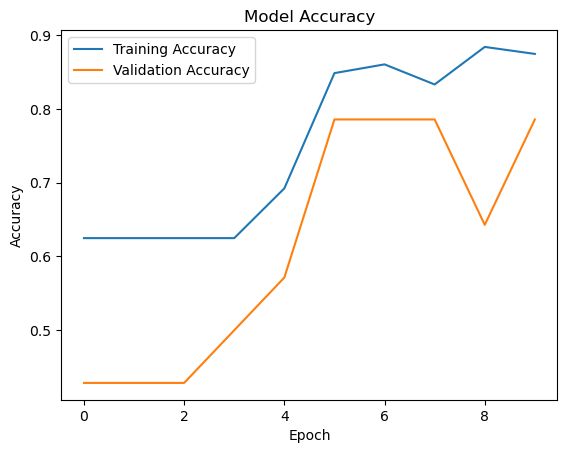

In [9]:
# Train the model
history = rnn_model.fit(train_features, train_labels, validation_data=(test_features, test_labels),
                       epochs=10, batch_size=32, verbose=1)

# Plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [10]:
test_loss, test_accuracy = rnn_model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7857 - loss: 0.4794
Test accuracy: 0.7857


In [13]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model

# افتراضات (استنادًا إلى الكود السابق)
IMG_HEIGHT = 224
IMG_WIDTH = 224
MAX_FRAMES = 20
NUM_CLASSES = 2  # non_shop_lifters: 0, shop_lifters: 1

# دالة تحميل الفيديو (كما في الكود السابق)
def load_video(path, max_frames=MAX_FRAMES, resize=(IMG_WIDTH, IMG_HEIGHT)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, resize)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) / 255.0  # Normalize
            frames.append(frame)
            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    # Pad or truncate to MAX_FRAMES
    while len(frames) < MAX_FRAMES:
        frames.append(np.zeros((IMG_HEIGHT, IMG_WIDTH, 3)))
    return np.array(frames)[:MAX_FRAMES]

# دالة استخراج الميزات (معدلة لفيديو واحد)
def extract_features_for_video(video_data):
    features = np.zeros((1, MAX_FRAMES, 128))  # 1 video, MAX_FRAMES frames, 128 features
    for j in range(MAX_FRAMES):
        frame = video_data[j]  # Shape: (224, 224, 3)
        features[0, j, :] = cnn_feature_extractor.predict(frame[None, ...])  # Add batch dim
    return features

# مسار الفيديو الذي تريد اختباره
video_path = r"C:\Users\DAR-MG\Documents\internship_cellula\video task\test\shop lifters\shop_lifter_85.mp4"  # استبدل بالمسار الفعلي

# تحميل الفيديو
test_video = load_video(video_path)

# استخراج الميزات
test_features = extract_features_for_video(test_video)

# تصنيف الفيديو باستخدام النموذج
prediction = rnn_model.predict(test_features)
predicted_class = np.argmax(prediction, axis=1)[0]
class_names = ['non_shop_lifters', 'shop_lifters']
print(f"التنبؤ: {class_names[predicted_class]}")
print(f"الاحتمالات: {prediction[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
التنبؤ: shop_lifters
الاحتمالات: [0.24483146 0.7551685 ]
